# Data Engineering

After the visualization process, we have to organize the data before applyinng the Machine Learning algorithms. Therefore, we shall handle missing data, data transformations, feature extraction, and feature selection. 

Load the necessary libraries and the data. 

In [222]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as pp
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# models 
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

## Definitions for the notebook

In [2]:
IMAGES_FOLDER = "../notes/images/"

sns.set()

pd.set_option('precision', 3)
pd.options.mode.chained_assignment = None

%matplotlib inline

## Importing the dataset

In [68]:
air_data = pd.read_csv("../data/RiodeJaneiro_MonitorAr_hourly_p1.csv", index_col = 0)
air_data.Data = pd.to_datetime(air_data.Data) 
air_data.head()

,Data,year,month,day,hour,CodNum,Lat,Lon,Chuva,Pres,RS,Temp,UR,Dir_Vento,Vel_Vento,CO,O3,PM10
326721,2011-01-01 00:30:00+00:00,2011,1,1,0,7,-22.898,-43.222,0.0,1009.60,2.87,26.66,90.73,180.00,0.47,0.03,8.47,8.00
387058,2011-01-01 00:30:00+00:00,2011,1,1,0,8,-22.925,-43.233,0.0,1007.45,6.40,20.91,89.49,176.83,2.92,0.13,5.08,44.05
103079,2011-01-01 00:30:00+00:00,2011,1,1,0,3,-22.908,-43.178,0.2,1009.33,1.57,21.81,84.50,250.67,0.34,0.17,17.89,10.00
163229,2011-01-01 00:30:00+00:00,2011,1,1,0,1,-22.965,-43.180,0.0,1009.52,0.70,24.09,79.79,157.00,0.90,0.15,3.68,34.64
387059,2011-01-01 01:30:00+00:00,2011,1,1,1,8,-22.925,-43.233,0.0,1006.57,6.50,20.53,92.83,211.17,2.82,0.13,11.90,55.89


## Missing data

We develop the following methods to handle the missing data. 

In [69]:
air_data_no_missing = air_data.dropna()

## Data transformation

We use the Power Transformer Yeo-Johnson in order to reduce heteroscedasticity in the dataset. The lambdas estimated are below. 

In [70]:
var_continuous = ['Chuva', 'Pres', 'RS', 'Temp', 'UR', 'Dir_Vento', 'Vel_Vento', 'CO', 'O3', 'PM10']

pt = pp.PowerTransformer(method = 'yeo-johnson', standardize=True)
pt.fit(air_data_no_missing[var_continuous])

PowerTransformer()

In [71]:
pt.lambdas_

array([-21.70192857,  11.98964551,  -0.11053925,   0.28313309,
         1.52643565,   0.86071829,  -0.80886639,  -1.75827312,
         0.25051017,   0.27130243])

In [72]:
transform_air_data = pt.transform(air_data_no_missing[var_continuous])

We can see the differences to the gases measured. 

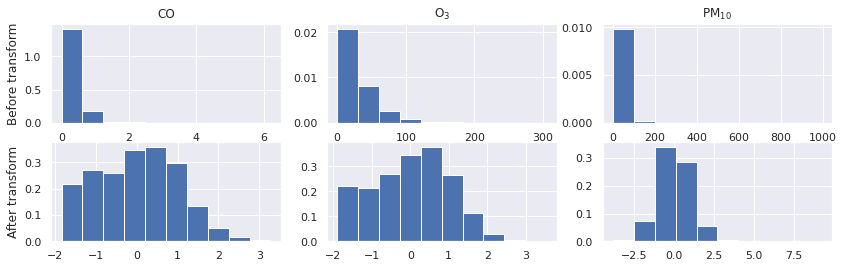

In [73]:
fig, ax = plt.subplots(2,3,figsize = (14,4))
air_data_no_missing.CO.plot.hist(ax = ax[0][0], density = True, title = 'CO')
air_data_no_missing.O3.plot.hist(ax = ax[0][1], density = True, title = r'O$_3$')
air_data_no_missing.PM10.plot.hist(ax = ax[0][2], density = True, title = r'PM$_{10}$')

ax[1][0].hist(transform_air_data[:,-3], density = True)
ax[1][1].hist(transform_air_data[:,-2], density = True)
ax[1][2].hist(transform_air_data[:,-1], density = True)

ax[0][0].set_ylabel("Before transform")
ax[1][0].set_ylabel("After transform")
ax[0][1].set_ylabel("")
ax[0][2].set_ylabel("")

plt.savefig(IMAGES_FOLDER + "before_after_transform_gases.eps", bbox_inches="tight")
plt.show()

In [74]:
air_data_no_missing[var_continuous] = transform_air_data

## Feature extraction

We add variables in order to help the estimates. We are putting season 0 (summer) to months January, February, and March, for instance. After, we need to ajust the months March, June, September, and December, because each one is divided between two seasons.

In [106]:
air_data_no_missing["weekend"] = air_data_no_missing.Data.dt.weekday >= 5
air_data_no_missing["season"] = (air_data_no_missing.month - 1)// 3

air_data_no_missing.season += (air_data_no_missing.month == 3)&(air_data_no_missing.day>=20)
air_data_no_missing.season += (air_data_no_missing.month == 6)&(air_data_no_missing.day>=21)
air_data_no_missing.season += (air_data_no_missing.month == 9)&(air_data_no_missing.day>=23)
air_data_no_missing.season += (air_data_no_missing.month == 12)&(air_data_no_missing.day>=21)

In [114]:
air_data_no_missing["hour_sin"] = np.sin(air_data_no_missing.hour*(2*np.pi/24))
air_data_no_missing["hour_cos"] = np.cos(air_data_no_missing.hour*(2*np.pi/24))

In [228]:
air_data.fillna(air_data.mean(), inplace = True)
s = air_data[(air_data.CodNum == 8)].CO

<ipython-input-228-091141f4ae14>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  air_data.fillna(air_data.mean(), inplace = True)


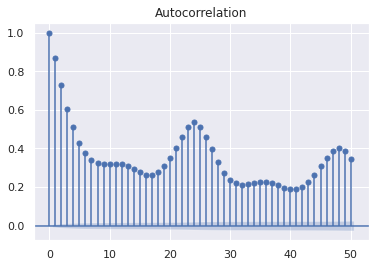

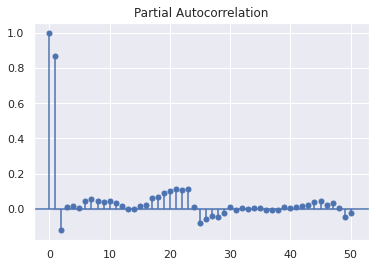

In [229]:
plot_acf(s)
plot_pacf(s)
plt.show()

In [231]:
air_data_no_missing[["hour", "hour_sin", "hour_cos"]].corr()

,hour,hour_sin,hour_cos
hour,1.000,-0.777,-0.103
hour_sin,-0.777,1.000,-0.002
hour_cos,-0.103,-0.002,1.000
